In [1]:
import sys
if not '..' in sys.path:
    sys.path.append('..')

In [2]:
from analysis import collection, analysis

from pathlib import Path
import json
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
from sklearn.decomposition import PCA
from analysis import analysis
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection
from matplotlib.colors import to_rgba
from IPython.display import HTML

from matplotlib.gridspec import GridSpec

import matplotlib as mpl
mpl.rcParams.update({'axes.labelsize': 16})

%matplotlib inline

image_path = Path("/Users/spencer/phd/phd/images/")

In [3]:
collection_name = "emg_olympics"
task_name = "center_hold"
c = collection.Collection(collection_name)
subjects = c.alphabetically_sorted_subjects()

In [4]:
test_subject = subjects[10]

## number of hits over subjects

In [6]:
hit_fractions = {}
hit_fraction_list = []
for subject in subjects:
    trial_list = []
    for session in subject.tasks[task_name].sorted_sessions():
        trial_list.extend(list(session.sorted_trials())) 
    num_trials = len(trial_list)
    hf = (sum([outcome["hits"] for outcome in [session.outcome_counts for session in subject.tasks[task_name].sorted_sessions()]]) / num_trials)
    hit_fractions[subject.name] = hf
    hit_fraction_list.append(hf)

In [7]:
subject_max_lens = []
for subject in subjects:
    max_len = 0
    for session in subject.tasks[task_name].sorted_sessions():
        for trial in session.sorted_trials():
            traj = trial.get_trajectory()
            hold_time = trial.hold_time
            if traj.shape[0] > max_len:
                max_len = traj.shape[0]
    subject_max_lens.append(max_len)

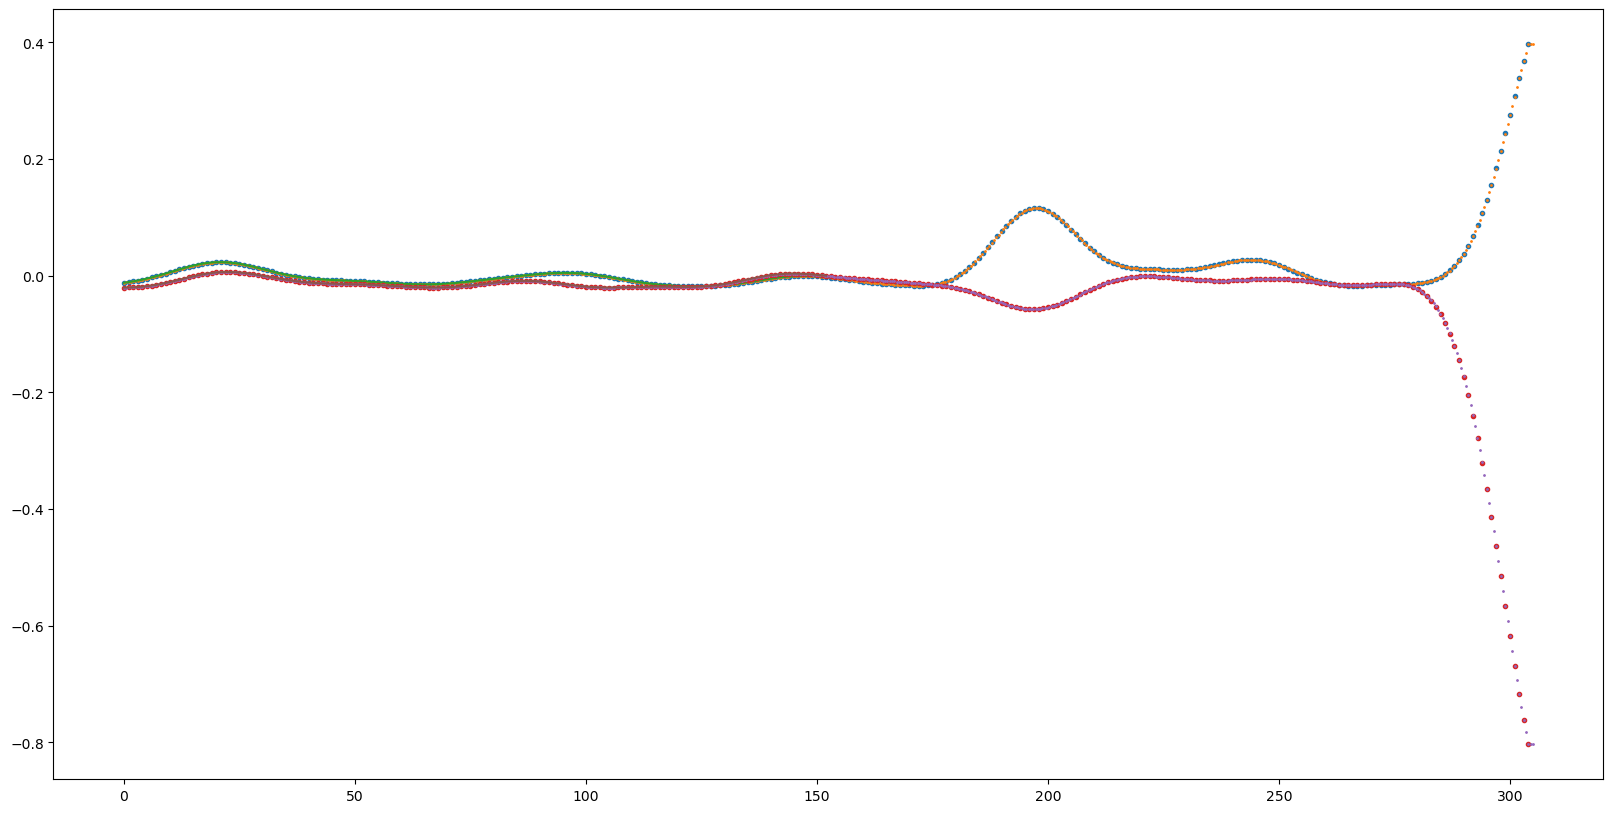

In [8]:
def interp_trajectory(x, traj):
    assert traj.shape[1] == 2
    assert traj.shape[0] > traj.shape[1]
    return np.column_stack([np.interp(x, np.arange(traj.shape[0]),traj[:,0]), np.interp(x, np.arange(traj.shape[0]),traj[:,1])])


x = np.linspace(0,traj.shape[0],traj.shape[0]*2)
interp_traj = interp_trajectory(x,traj)

plt.figure(figsize=(20,10))
plt.plot(traj[:,0],".")
plt.plot(x,interp_traj[:,0],".",markersize=2)
plt.plot(traj[:int(200*hold_time),0])

plt.plot(traj[:,1],".")
plt.plot(x,interp_traj[:,1],".",markersize=2)
plt.plot(traj[:int(200*hold_time),1])

In [9]:
for trial_idx, trial in enumerate(session.sorted_trials()):
    print(trial.target_number, trial.recorded_number, trial.number)

8 0 0
3 1 1
9 2 2
10 3 3
4 4 4
2 5 5
6 6 6
1 7 7
7 8 8
7 8 9
5 9 10
12 10 11
11 11 12


In [10]:
def count_nan(data):
    return np.count_nonzero(np.isnan(data))

max_traj_len = 0
for subject in subjects:
    for session in subject.tasks[task_name].sorted_sessions():
        for trial in session.sorted_trials():
            hold_steps = int(200*trial.hold_time)
            traj = trial.get_trajectory()[hold_steps:,:]
            if traj.shape[0] > max_len:
                max_len = traj.shape[0]
print("Max trajectory length: " , max_len)

x = np.arange(0,max_len)
interp_traj_stack = np.empty(shape=(len(subjects), 15, 12, max_len, 2))
interp_traj_stack[:] = np.nan
for subject_idx, subject in enumerate(subjects):
    for session_idx, session in enumerate(subject.tasks[task_name].sorted_sessions()[:15]):
        for target_idx in range(1,13):
            for trial_idx, trial in enumerate(session.sorted_trials()):
                if trial.outcome != "No Hold" and trial.target_number == target_idx:
                    hold_steps = int(200*trial.hold_time)
                    traj = trial.get_trajectory()[hold_steps:,:]
                    if traj.shape[0] < max_len:
                        interp_traj_stack[subject_idx, session_idx, target_idx-1, :, :] = interp_trajectory(x,traj[:,:])
                    else:
                        interp_traj_stack[subject_idx, session_idx, target_idx-1, :, :] = traj[:,:]

print(interp_traj_stack.shape)
print(count_nan(interp_traj_stack))

Max trajectory length:  1589
(46, 15, 12, 1589, 2)
66738


## hand-picked subjects

In [ ]:
best_subjects = [subjects[i] for i in [0, 6, 15, 16, 27, 29, 35, 37, 42]]
very_best_subjects = [subjects[i] for i in [0, 29]]

## plot mean trajectories

In [ ]:
traj_std = np.nanstd(interp_traj_stack,axis=(1))
traj_mean = np.nanmean(interp_traj_stack[:,2:,:,:,:],axis=(1))
for subject_idx in range(46):
    plt.figure(figsize=(10,10))
    plt.suptitle(f"Subject {subject_idx}")
    for target_idx in range(12):
        target_vec = collection.compute_target_vec_from_number(target_idx+1)
        plt.plot(target_vec[0],target_vec[1],"ro")
        for i in range(15): 
            try:
                plt.plot(interp_traj_stack[subject_idx,i,target_idx,:,0],interp_traj_stack[subject_idx,i,target_idx,:,1],"k",alpha=0.1)
            except:
                continue
        plt.plot(traj_mean[subject_idx,target_idx,:,0],traj_mean[subject_idx,target_idx,:,1])
    plt.xlim([-1,1])
    plt.ylim([-1,1])

## rotate the targets

In [ ]:
def make_2d_rotation_matrix(angle):
    return np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]).T

def rotation_matrix_from_target(target):
    # assume [x, y]
    assert target.shape == (2,), target.shape
    # the "closest" angle between the two targettors
    theta = np.arctan2(target[1],target[0])
    R = make_2d_rotation_matrix(theta)
    return R

def rotate(R, vec):
    return R @ vec


traj_std = np.nanstd(interp_traj_stack,axis=(1))
traj_mean = np.nanmean(interp_traj_stack[:,2:,:,:,:],axis=(1))
for subject_idx in range(46):
    plt.figure(figsize=(10,10))
    plt.suptitle(f"Subject {subject_idx}")
    for target_idx in range(12):
        target_vec = collection.compute_target_vec_from_number(target_idx+1)
        R = rotation_matrix_from_target(np.array(target_vec))
        t = R @ target_vec
        plt.plot(t[0],t[1],"ro")
        for i in range(15):
            try:
                tr = R @ interp_traj_stack[subject_idx,i,target_idx].T
                plt.plot(tr[0],tr[1],"k",alpha=0.1)
            except:
                continue
        trm = R @ traj_mean[subject_idx,target_idx].T
        plt.plot(trm[0],trm[1])
    plt.xlim([-1,1.5])
    plt.ylim([-1,1])

## plot random EMG

In [25]:
decoder = test_subject.decoder[-2:,:]

### uniform

(5000, 2)


(array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   3.,   0.,
           1.,   0.,   2.,   2.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   2.,   3.,   6.,
           5.,   5.,   0.,   0.,   1.,   0.,   0.,   1.,   0.],
        [  0.,   0.,   0.,   0.,   1.,   1.,   3.,   3.,   5.,  10.,   8.,
           5.,  16.,   6.,   3.,   1.,   2.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   2.,   3.,   5.,   5.,  10.,  18.,  18.,  24.,
          15.,  14.,  13.,   9.,   5.,   6.,   0.,   0.,   1.],
        [  0.,   0.,   1.,   1.,   3.,  12.,  26.,  23.,  35.,  52.,  48.,
          35.,  27.,  25.,  11.,   6.,   3.,   2.,   1.,   0.],
        [  0.,   0.,   0., 

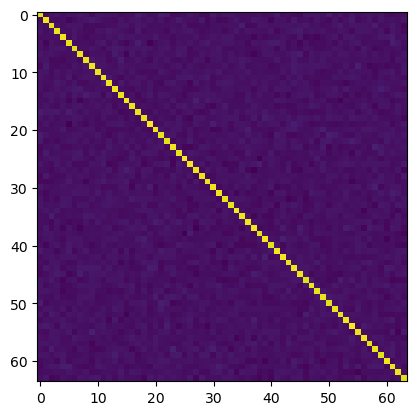

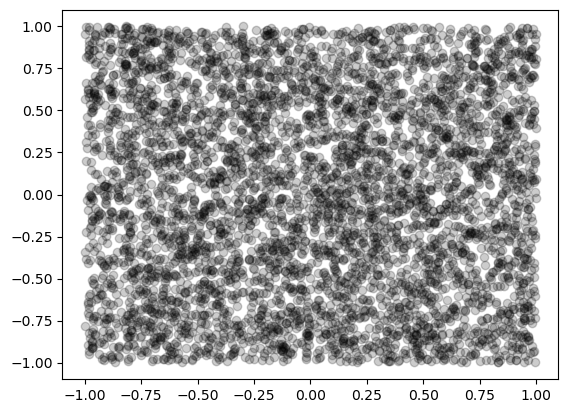

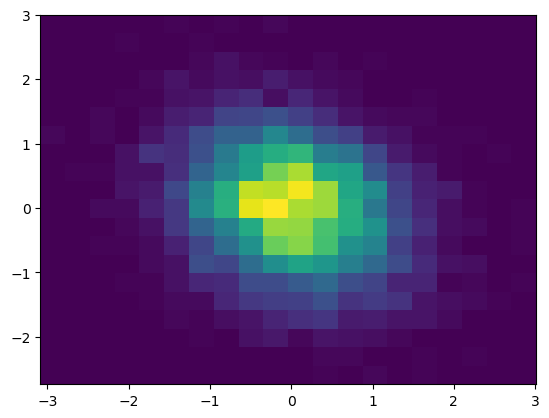

In [105]:
# 1000, 64
X = np.random.uniform(low=-1,high=1,size=(5000,64))
plt.imshow(np.cov(X.T))

# 1000, 2
T = X @ subjects[0].decoder[-2:,:].T
# T = X @ (np.ones(shape=(64,2))/64)
print(T.shape)

plt.figure()
plt.scatter(X[:,0],X[:,1],color="k",alpha=0.2)

plt.figure()
plt.hist2d(T[:,0],T[:,1],bins=20)

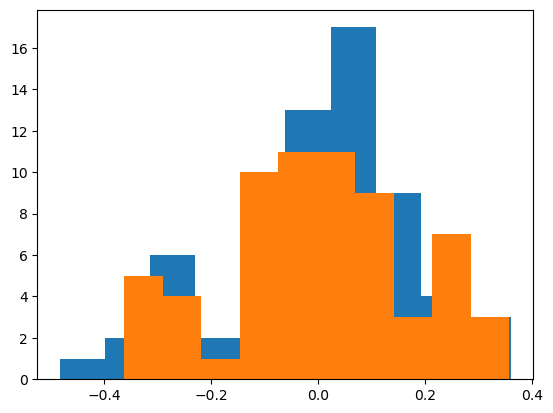

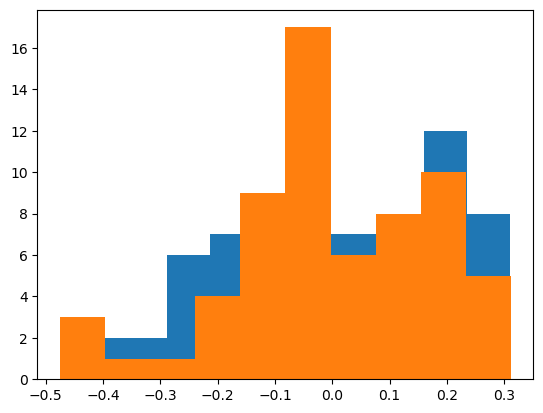

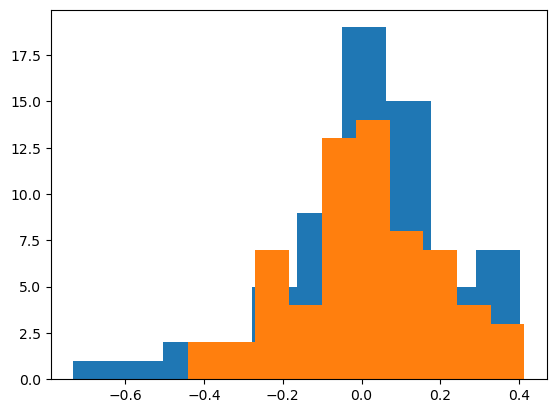

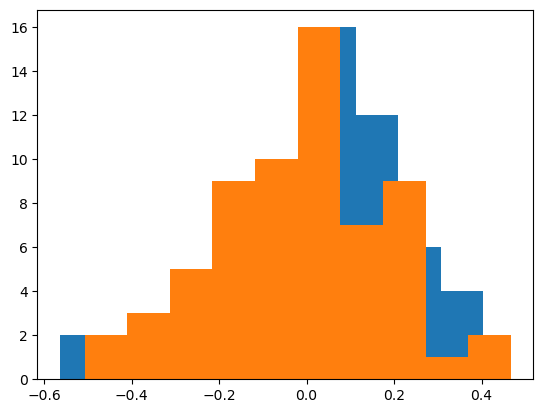

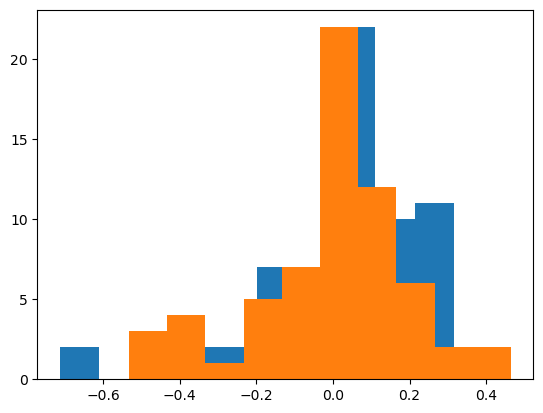

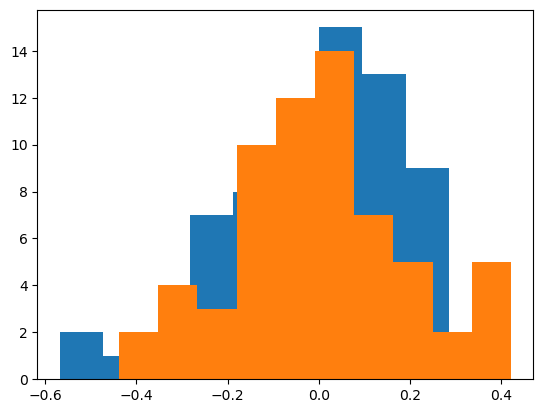

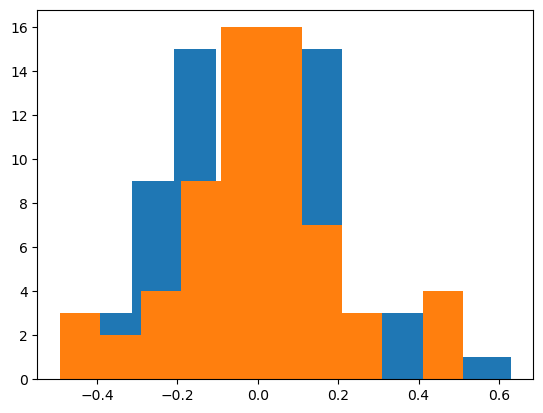

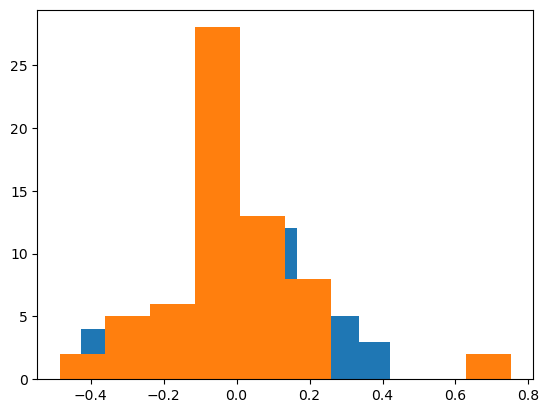

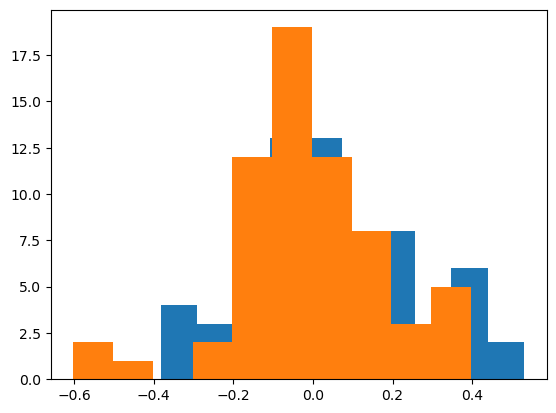

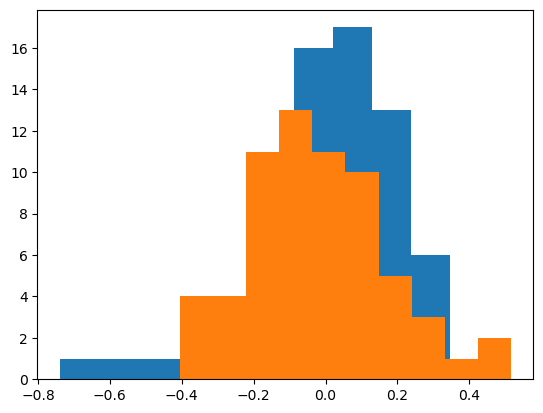

In [96]:
for i in range(10):
    decoder = subjects[i].decoder[-2:,:]
    plt.figure()
    plt.hist(decoder[0])
    plt.hist(decoder[1])

### try using a gaussian decoder

(array([ 1.,  6.,  7., 10., 12.,  9.,  8.,  5.,  5.,  1.]),
 array([-2.12593238, -1.65978272, -1.19363307, -0.72748342, -0.26133376,
         0.20481589,  0.67096555,  1.1371152 ,  1.60326486,  2.06941451,
         2.53556416]),
 <BarContainer object of 10 artists>)

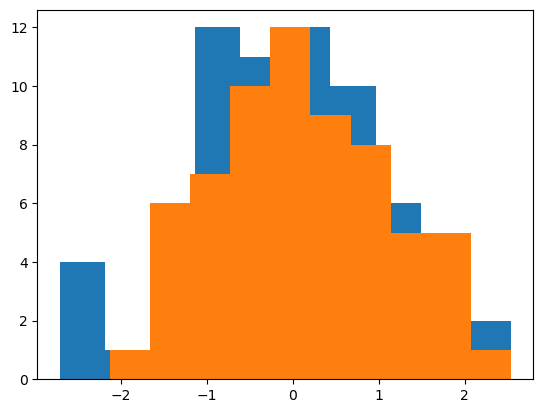

In [8]:
gaussian_decoder = np.random.multivariate_normal(mean=np.zeros(64),cov=np.eye(64),size=(2))
plt.hist(gaussian_decoder[0])
plt.hist(gaussian_decoder[1])

(5000, 2)


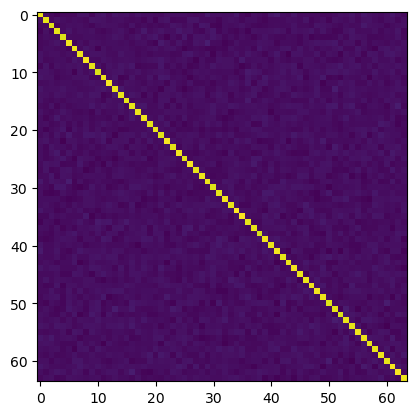

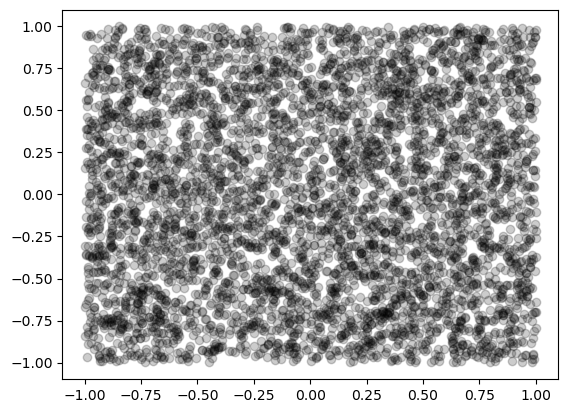

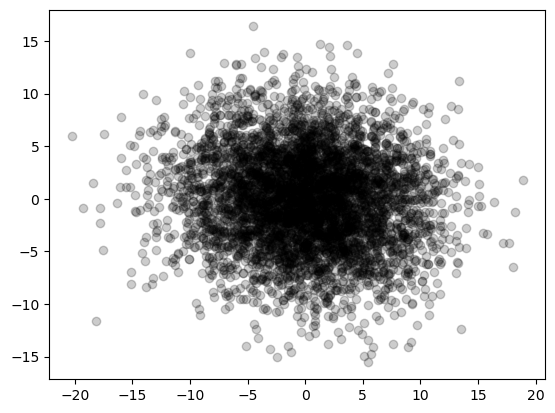

In [9]:
# 1000, 64
X = np.random.uniform(low=-1,high=1,size=(5000,64))
plt.imshow(np.cov(X.T))

# 1000, 2
T = X @ gaussian_decoder.T
# T = X @ (np.ones(shape=(64,2))/64)
print(T.shape)

plt.figure()
plt.scatter(X[:,0],X[:,1],color="k",alpha=0.2)

plt.figure()
plt.scatter(T[:,0],T[:,1],color="k",alpha=0.2)

### standard gaussian input

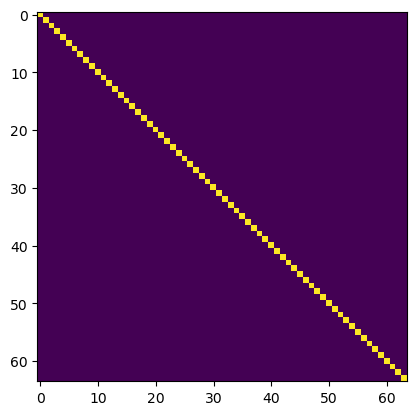

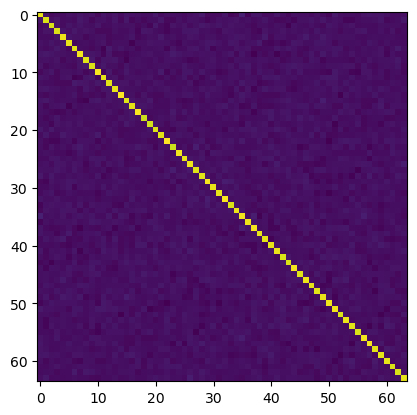

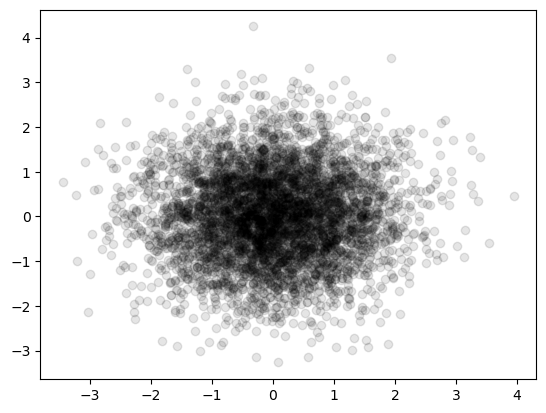

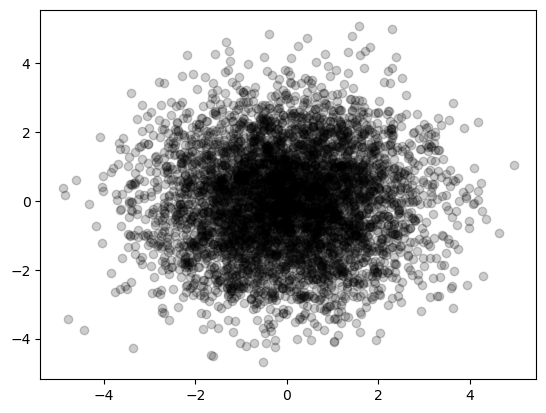

In [26]:
mean = np.zeros(shape=(64))
cov = np.eye(64)
plt.imshow(cov)

# 1000, 64
X = np.random.multivariate_normal(mean, cov, size=5000)
plt.figure()
plt.imshow(np.cov(X.T))
plt.figure()
plt.scatter(X[:,0],X[:,1],color="k",alpha=0.1)

# 1000, 2
T = X @ decoder.T

plt.figure()
plt.scatter(T[:,0],T[:,1],color="k",alpha=0.2)

## gaussian input with empirical covariance

(316, 64)


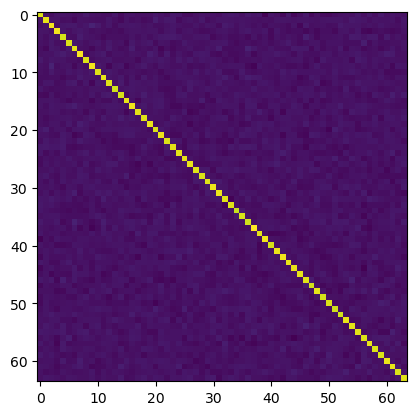

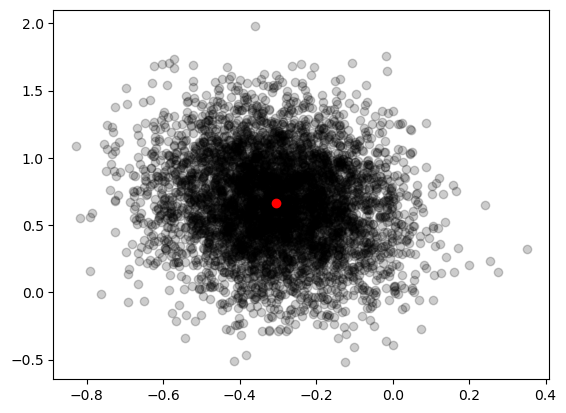

In [12]:
# use the last session, 
trials = test_subject.tasks[task_name].sorted_sessions()[-1].sorted_trials()
trial = trials[4]
emg = trial.get_filtered_emg()[trial.active_indices]
print(emg.shape)

mean = np.mean(emg,axis=0)
cov = np.cov(emg.T)
plt.imshow(np.cov(X.T))

# 1000, 64
X = np.random.multivariate_normal(mean, cov, size=5000)

# 1000, 2
T = X @ decoder.T

plt.figure()
plt.scatter(T[:,0],T[:,1],color="k",alpha=0.2)
t_mean = np.mean(T,axis=0)
plt.plot(t_mean[0],t_mean[1],"ro")


## look at distributions of emg per channel 

In [ ]:
fig, axes = plt.subplots(64,1,figsize=(10,100))
for i, emg_channel in enumerate(emg.T):
    axes[i].hist(emg_channel)

## try a gamma distribution 

(5000, 2)


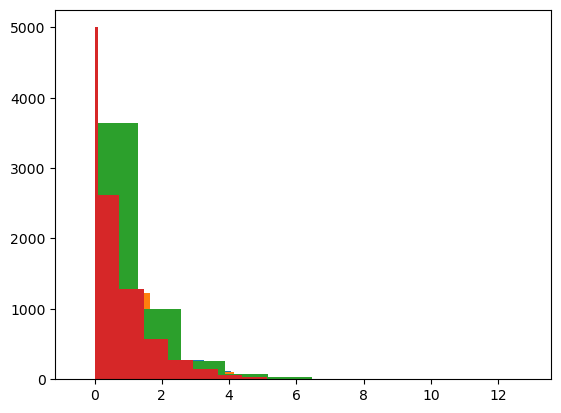

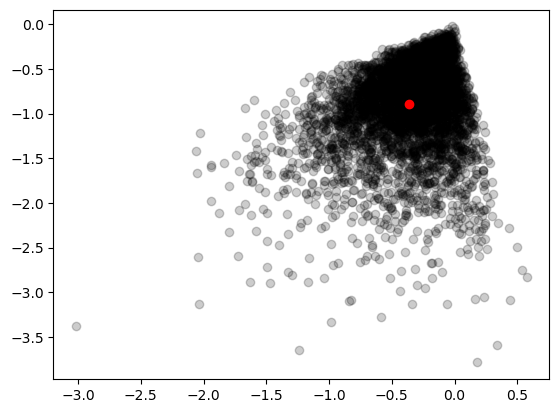

In [14]:
# 1000, 64
R = np.random.gamma(shape=1,scale=np.ones(64), size=(5000,64))
X = np.zeros(shape=(5000,64))
X[:,10:14] = R[:,10:14]
for xx in X.T:
    plt.hist(xx)

# 1000, 2
T = X @ decoder.T

print(T.shape)

plt.figure()
plt.scatter(T[:,0],T[:,1],color="k",alpha=0.2)
t_mean = np.mean(T,axis=0)
plt.plot(t_mean[0],t_mean[1],"ro")

## put natural movement through decoder to look for X pattern

(1000, 2)


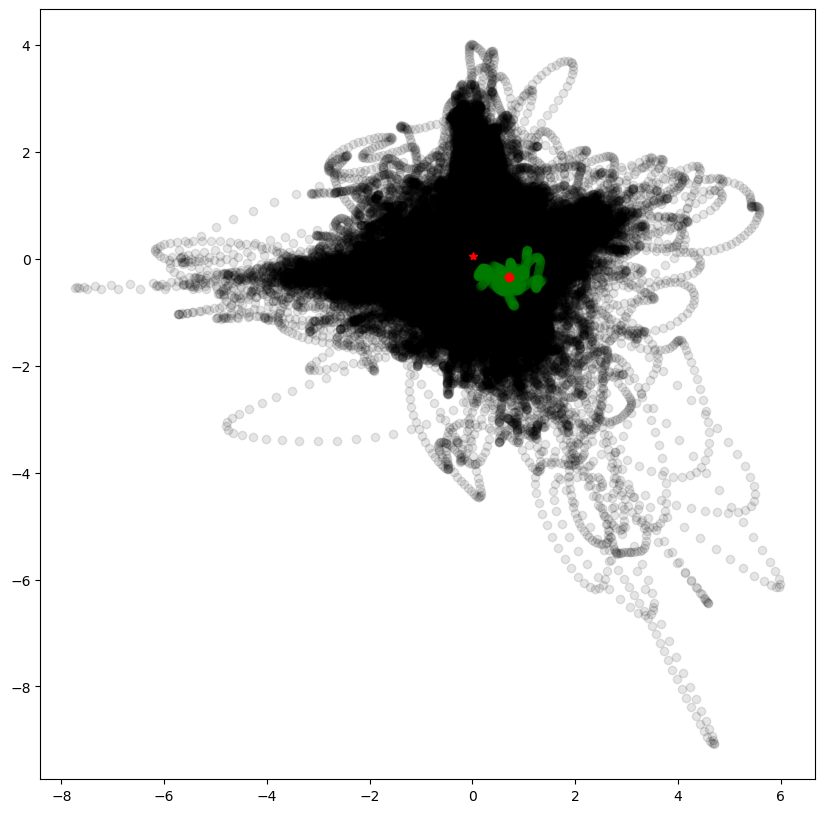

In [ ]:
plt.figure(figsize=(10,10))
for session in test_subject.tasks[task_name].sorted_sessions():
    for trial in session.sorted_trials():
        X = trial.get_trajectory()[trial.active_indices]
        plt.scatter(X[:,0],X[:,1],color="k",alpha=0.1)
t_mean = np.nanmean(X,axis=0)
plt.plot(t_mean[0],t_mean[1],"r*")

T = natural_movement_stack[0] @ test_subject.decoder[-2:,:].T
plt.scatter(T[:,0],T[:,1],color="g",alpha=0.2)
t_mean = np.nanmean(T,axis=0)
plt.plot(t_mean[0],t_mean[1],"ro")

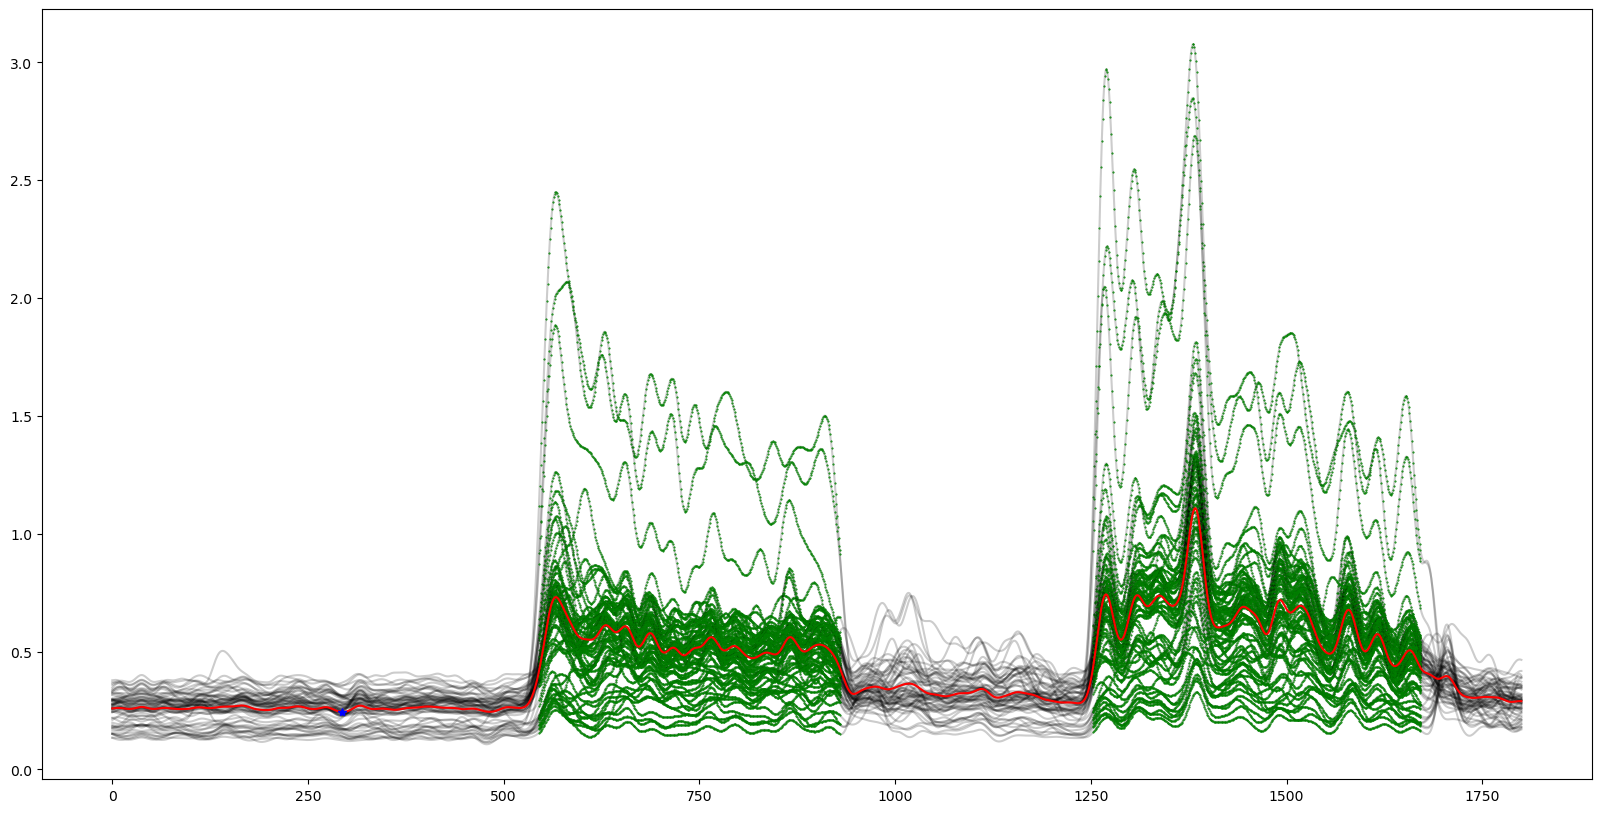

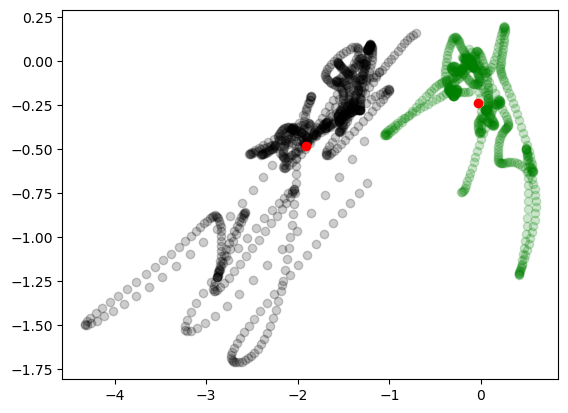

In [37]:

fig, ax = plt.subplots(1,1,figsize=(20,10))
for channel in range(64):
    ax.plot(filtered[:, channel], "k", alpha=0.2)
    ax.plot(indices, filtered[indices, channel], "g.", markersize=1)

mean_sig = np.mean(filtered,axis=1)
ax.plot(mean_sig, "r")
ax.plot(low_point, mean_sig[low_point], "b*")

plt.figure()
plt.scatter(projected_movement[:,0],projected_movement[:,1],color="k",alpha=0.2,label="natural movement")
t_mean = np.mean(projected_movement,axis=0)
plt.plot(t_mean[0],t_mean[1],"ro")

plt.scatter(T[:,0],T[:,1],color="g",alpha=0.2,label="trial movement")
t_mean = np.mean(T,axis=0)
plt.plot(t_mean[0],t_mean[1],"ro")


## plot all the natural movement as a 2D histogram
## overlay all trajectories as 2D histogram

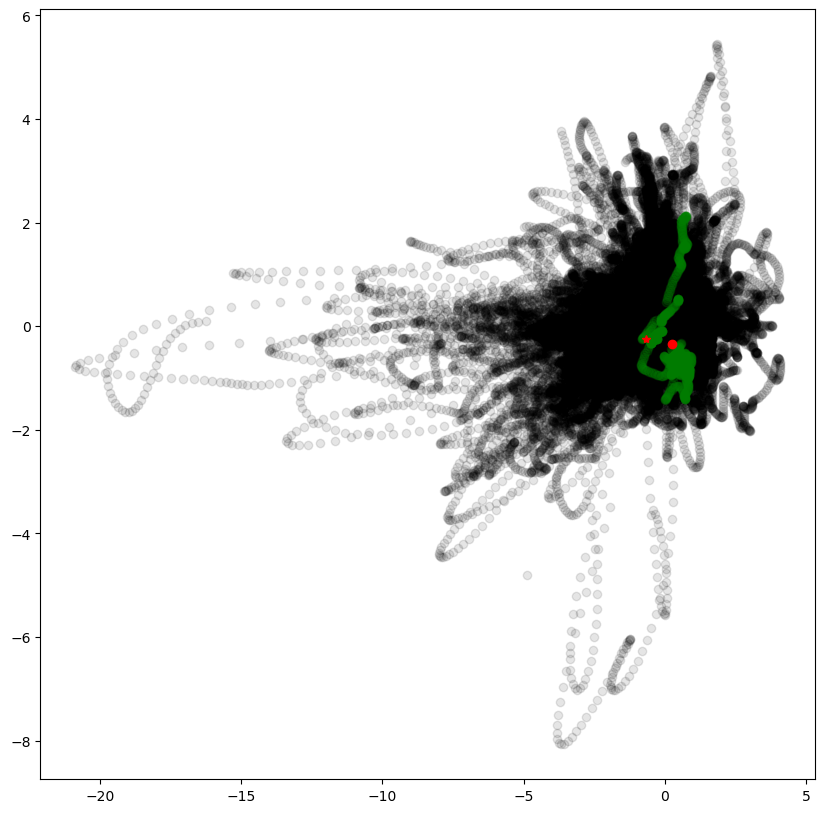

In [27]:
plt.figure(figsize=(10,10))
for session in test_subject.tasks[task_name].sorted_sessions():
    for trial in session.sorted_trials():
        X = trial.get_trajectory()[trial.active_indices]
        plt.scatter(X[:,0],X[:,1],color="k",alpha=0.1)
t_mean = np.nanmean(X,axis=0)
plt.plot(t_mean[0],t_mean[1],"r*")

T = natural_movement_stack[0] @ test_subject.decoder[-2:,:].T
plt.scatter(T[:,0],T[:,1],color="g",alpha=0.2)
t_mean = np.nanmean(T,axis=0)
plt.plot(t_mean[0],t_mean[1],"ro")

sns.kdeplot()

(1000, 2)


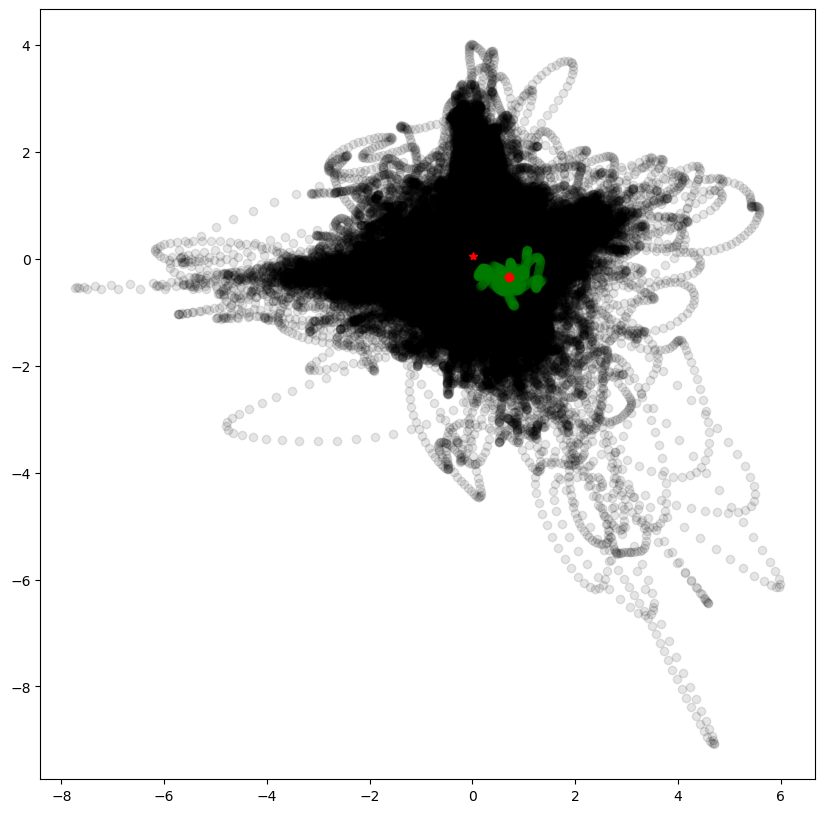

In [72]:
plt.figure(figsize=(10,10))
for session in test_subject.tasks[task_name].sorted_sessions():
    for trial in session.sorted_trials():
        X = trial.get_trajectory()[trial.active_indices]
        plt.scatter(X[:,0],X[:,1],color="k",alpha=0.1)
t_mean = np.nanmean(X,axis=0)
plt.plot(t_mean[0],t_mean[1],"r*")

T = natural_movement_stack[0] @ test_subject.decoder[-2:,:].T
plt.scatter(T[:,0],T[:,1],color="g",alpha=0.2)
t_mean = np.nanmean(T,axis=0)
plt.plot(t_mean[0],t_mean[1],"ro")

## pairwise plot of a single trial's active emg

In [ ]:
trial = test_subject.tasks["center_hold"].sorted_sessions()[-1].sorted_trials()[3]
emg = trial.get_filtered_emg()[trial.active_indices]

idxs = np.arange(0,65,16)
df = pd.DataFrame(emg, columns=[f"Channel {i}" for i in range(64)])
for start, stop in zip(idxs[:-1], idxs[1:]):
    sns.pairplot(df.iloc[:, start:stop], diag_kind="kde", kind="kde")

## try an early trial

In [ ]:
trial = test_subject.tasks["center_hold"].sorted_sessions()[5].sorted_trials()[3]
emg = trial.get_filtered_emg()[trial.active_indices]

import seaborn as sns
import pandas as pd
idxs = np.arange(0,65,16)
df = pd.DataFrame(emg, columns=[f"Channel {i}" for i in range(64)])
for start, stop in zip(idxs[:-1], idxs[1:]):
    sns.pairplot(df.iloc[:, start:stop], diag_kind="kde", kind="kde")

## gaussian eigenvector outer product

[[ 1. -5.]
 [-5. 10.]]
[-1.22681202 12.22681202]
[[1.25595249 0.55935402]
 [0.55935402 0.24911525]]
[[ 24.74404751 -55.55935402]
 [-55.55935402 124.75088475]]


/var/folders/dz/870p8tdx43j5527kzthy65zw0000gn/T/ipykernel_58547/1549307651.py:8: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(np.zeros(2),covariance,size=2000)


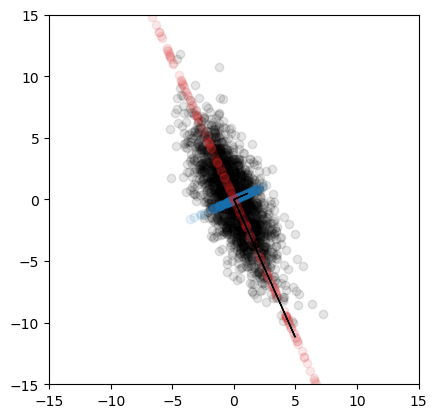

In [176]:
covariance = np.zeros(shape=(2,2))
covariance[0,0] = 1
covariance[1,1] = 10
covariance[1,0] = covariance[0,1] = -5

print(covariance)

samples = np.random.multivariate_normal(np.zeros(2),covariance,size=2000)

plt.figure()
plt.xlim(-15,15)
plt.ylim(-15,15)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.scatter(samples[:,0],samples[:,1], color="k", alpha=0.1,label="og")

eigs, vecs = np.linalg.eig(covariance)

print(eigs)

# why this way around?
# columns are vectors
# multiply whole column by each eigenvalue
vecs = vecs @ np.diag(eigs)

outer_1 = np.outer(vecs[:,0], vecs[:,0])
outer_2 = np.outer(vecs[:,1], vecs[:,1])

print(outer_1)
print(outer_2)

# plot gaussians based on outer products
samples = np.random.multivariate_normal(np.zeros(2),outer_1,size=200)
plt.scatter(samples[:,0],samples[:,1], color="tab:blue", alpha=0.1,label="1")

samples = np.random.multivariate_normal(np.zeros(2),outer_2,size=200)
plt.scatter(samples[:,0],samples[:,1], color="tab:red", alpha=0.1, label="2")

# vec 1
plt.arrow(0,0,vecs[0,0],vecs[1,0])
# vec 2
plt.arrow(0,0,vecs[0,1],vecs[1,1])

## single gaussian for X pattern

/var/folders/dz/870p8tdx43j5527kzthy65zw0000gn/T/ipykernel_63166/3501994024.py:7: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = pd.DataFrame(np.random.multivariate_normal(np.ones(64),cov,size=500),columns=[f"Ch {k}" for k in range(64)])


(500, 64)


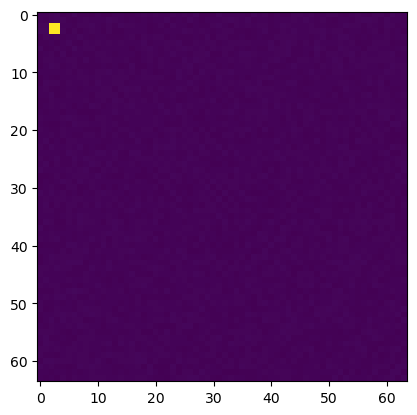

<Figure size 640x480 with 0 Axes>

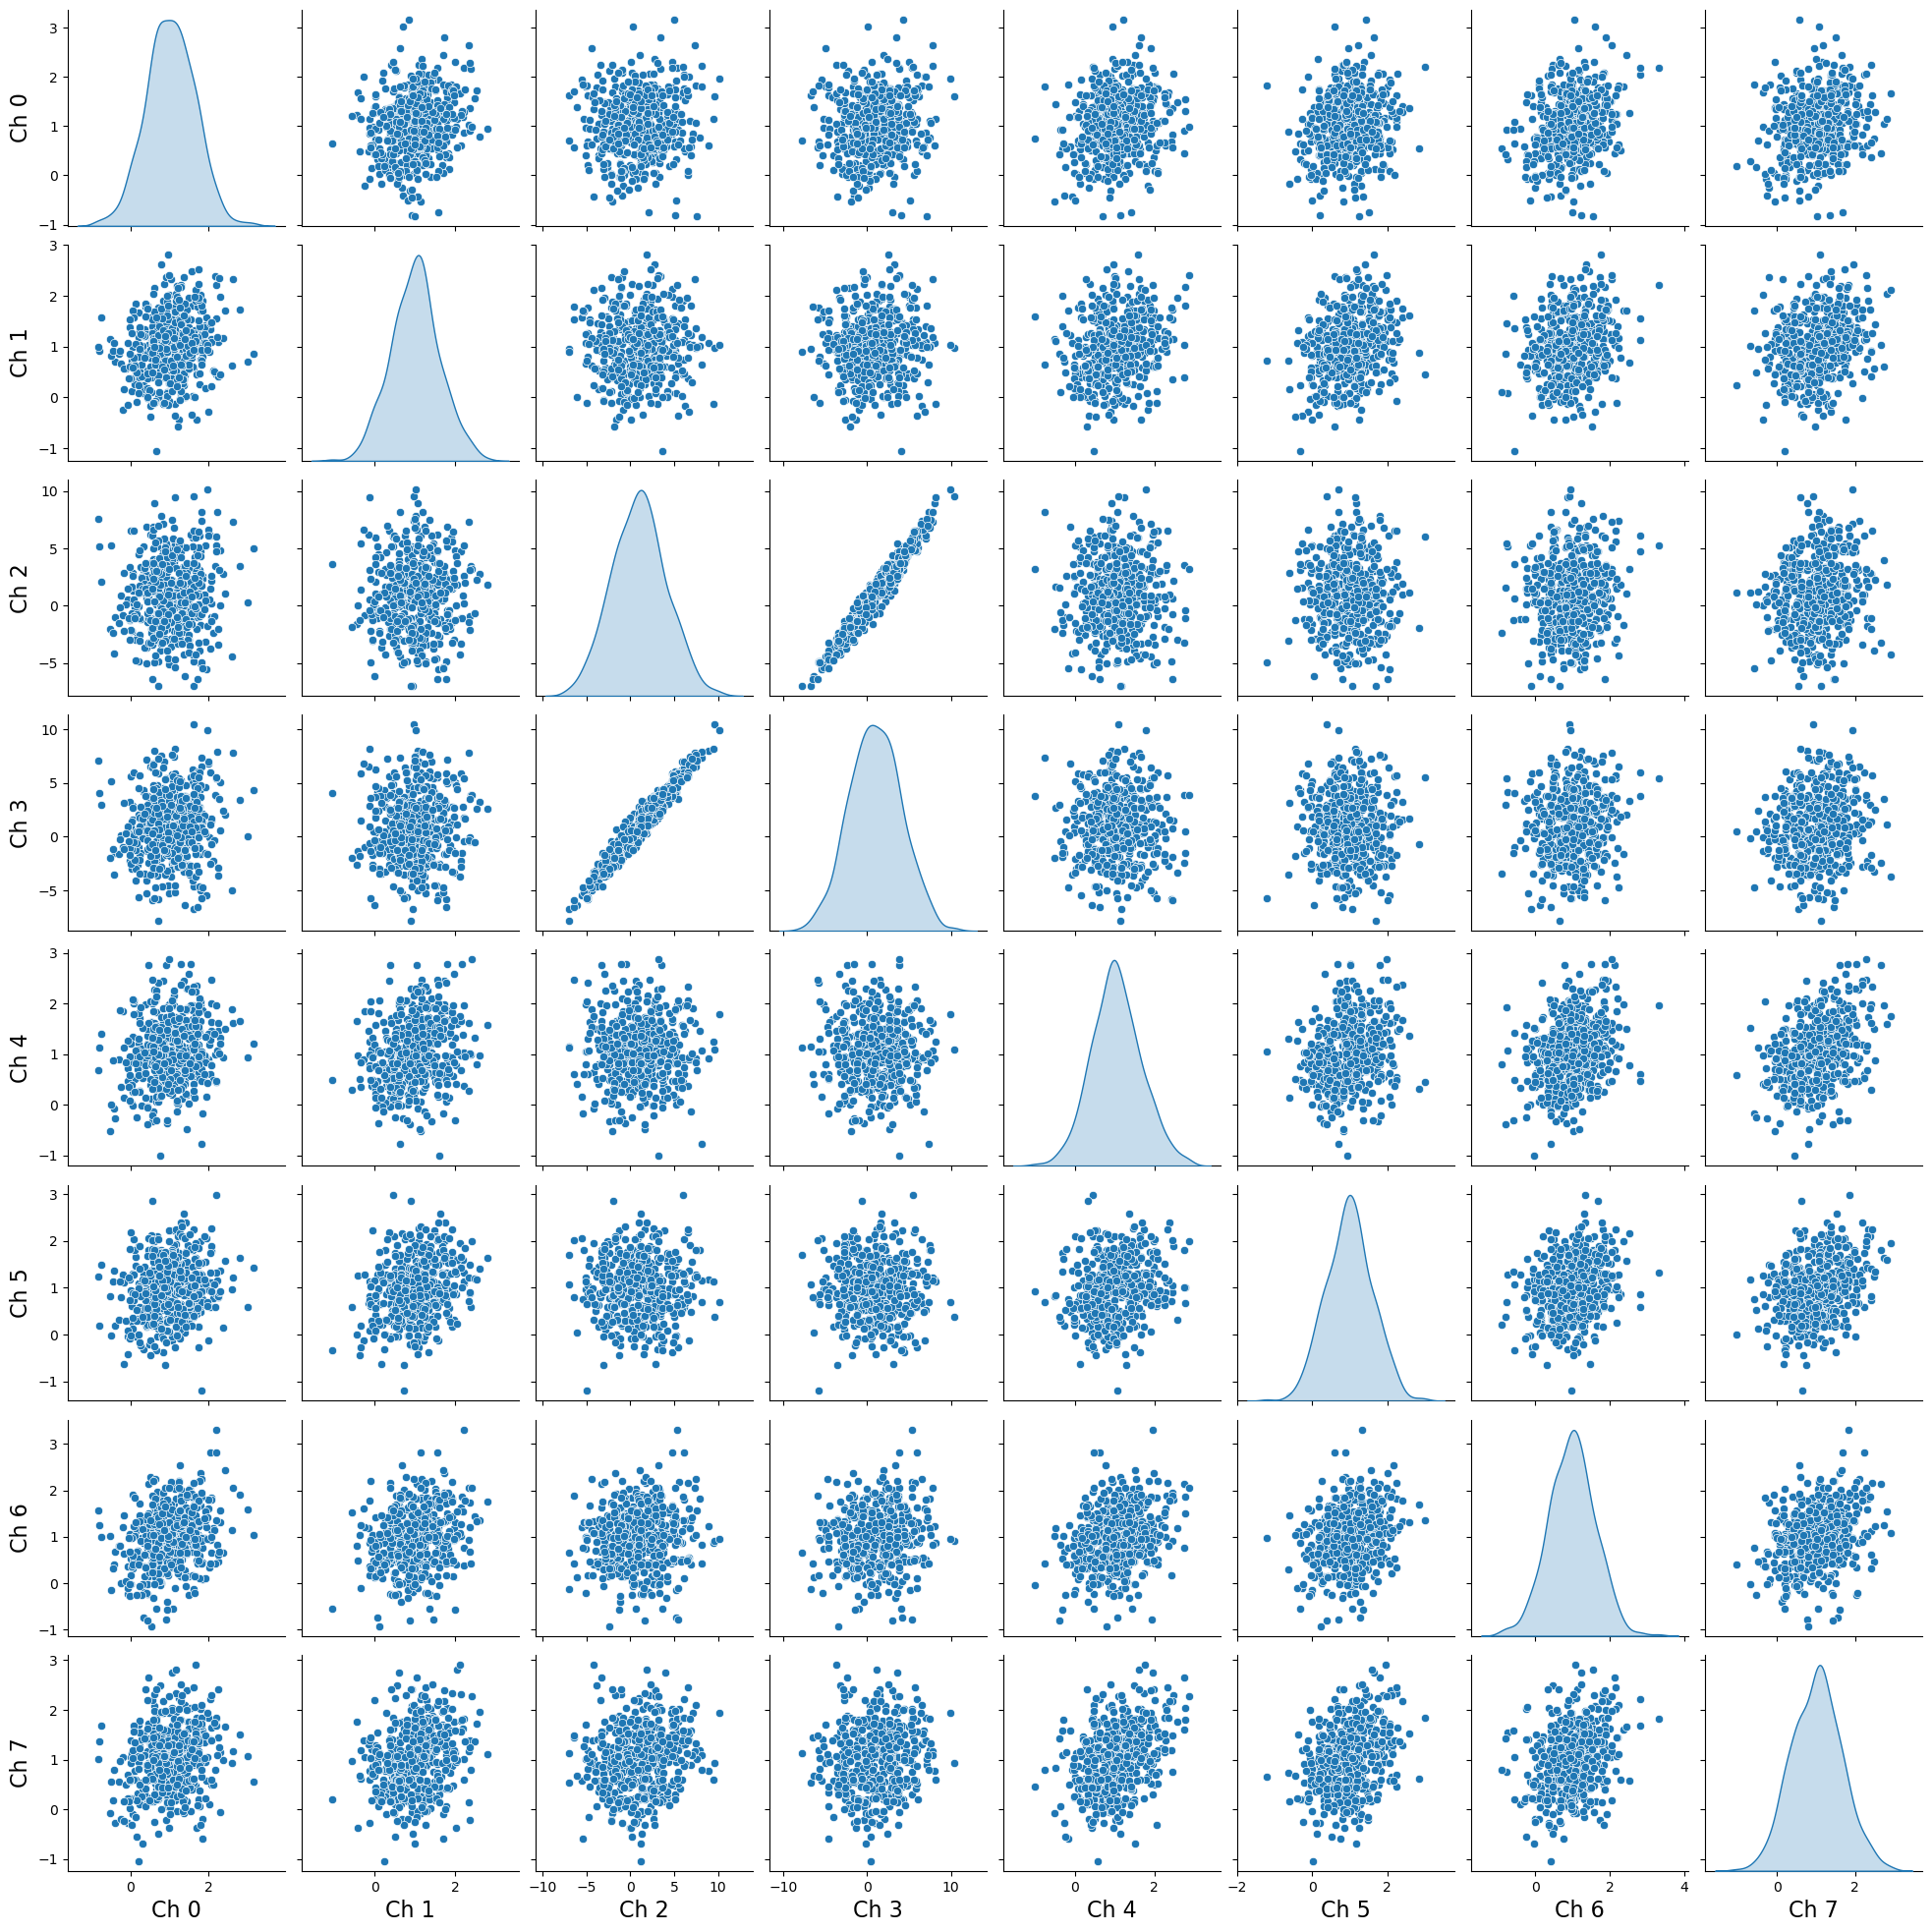

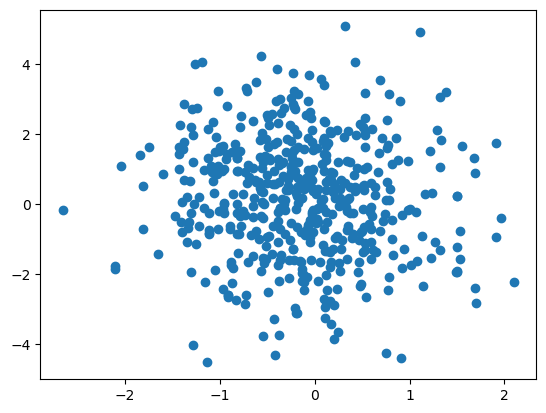

In [44]:
cov = np.random.random(size=(64,64))*0.1
cov += cov.T
i = 3
cov[i-1:i+1,i-1:i+1] = 10
plt.imshow(cov)

samples = pd.DataFrame(np.random.multivariate_normal(np.ones(64),cov,size=500),columns=[f"Ch {k}" for k in range(64)])
print(samples.shape)
plt.figure()
sns.pairplot(samples.iloc[:,:8], diag_kind="kde")

decoder = test_subject.decoder[-2:,:]
output = decoder @ samples.T

plt.figure()
plt.plot(output.iloc[0],output.iloc[1],"o")

## toy mixture model

(4, 8, 8)
(1000, 8)


/var/folders/dz/870p8tdx43j5527kzthy65zw0000gn/T/ipykernel_63166/2588488831.py:25: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = pd.DataFrame(np.array([np.random.multivariate_normal(means[i], covariances[i]) for i in mixture_idxs]),columns=[f"Ch {j}" for j in range(n_dimensions)])


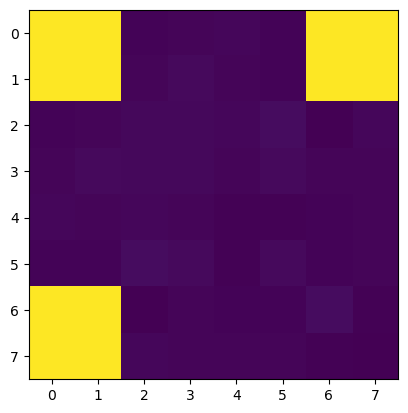

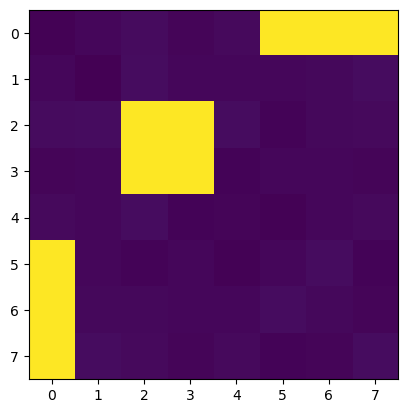

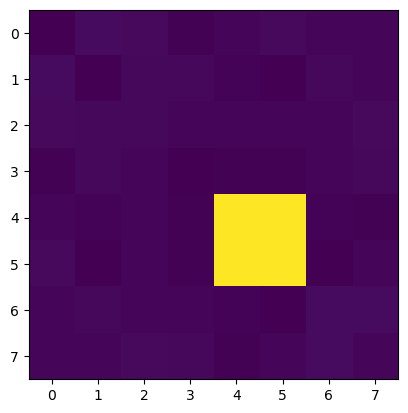

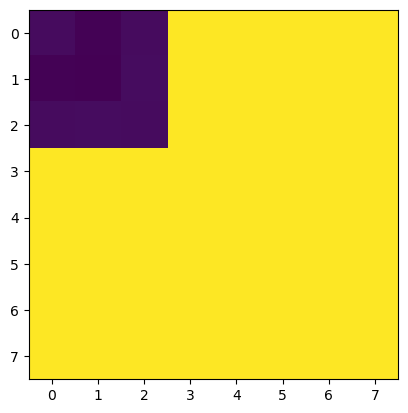

In [62]:
# mixture of gaussians 

n_dimensions = 8
n_gaussians = 4
n_samples = 1000
mixture_weights = np.ones(shape=(n_gaussians)) / n_gaussians

mixture_idxs = np.random.choice(n_gaussians, size=n_samples, replace=True, p=mixture_weights)
means = np.row_stack([np.ones(n_dimensions) for _ in range(n_gaussians)])
covariances = []
multiple = n_dimensions//n_gaussians
for i in range(n_gaussians):
    cov = np.random.random(size=(n_dimensions,n_dimensions))*0.1 
    cov += cov.T
    k = i*multiple
    cov[k:k+multiple,k:k+multiple] = 5
    cov[-multiple-i:,:multiple-i] = 5
    cov[:multiple-i,-multiple-i:] = 5
    covariances.append(cov)
    plt.figure()
    plt.imshow(cov)
covariances = np.array(covariances)
print(covariances.shape)

samples = pd.DataFrame(np.array([np.random.multivariate_normal(means[i], covariances[i]) for i in mixture_idxs]),columns=[f"Ch {j}" for j in range(n_dimensions)])
print(samples.shape)

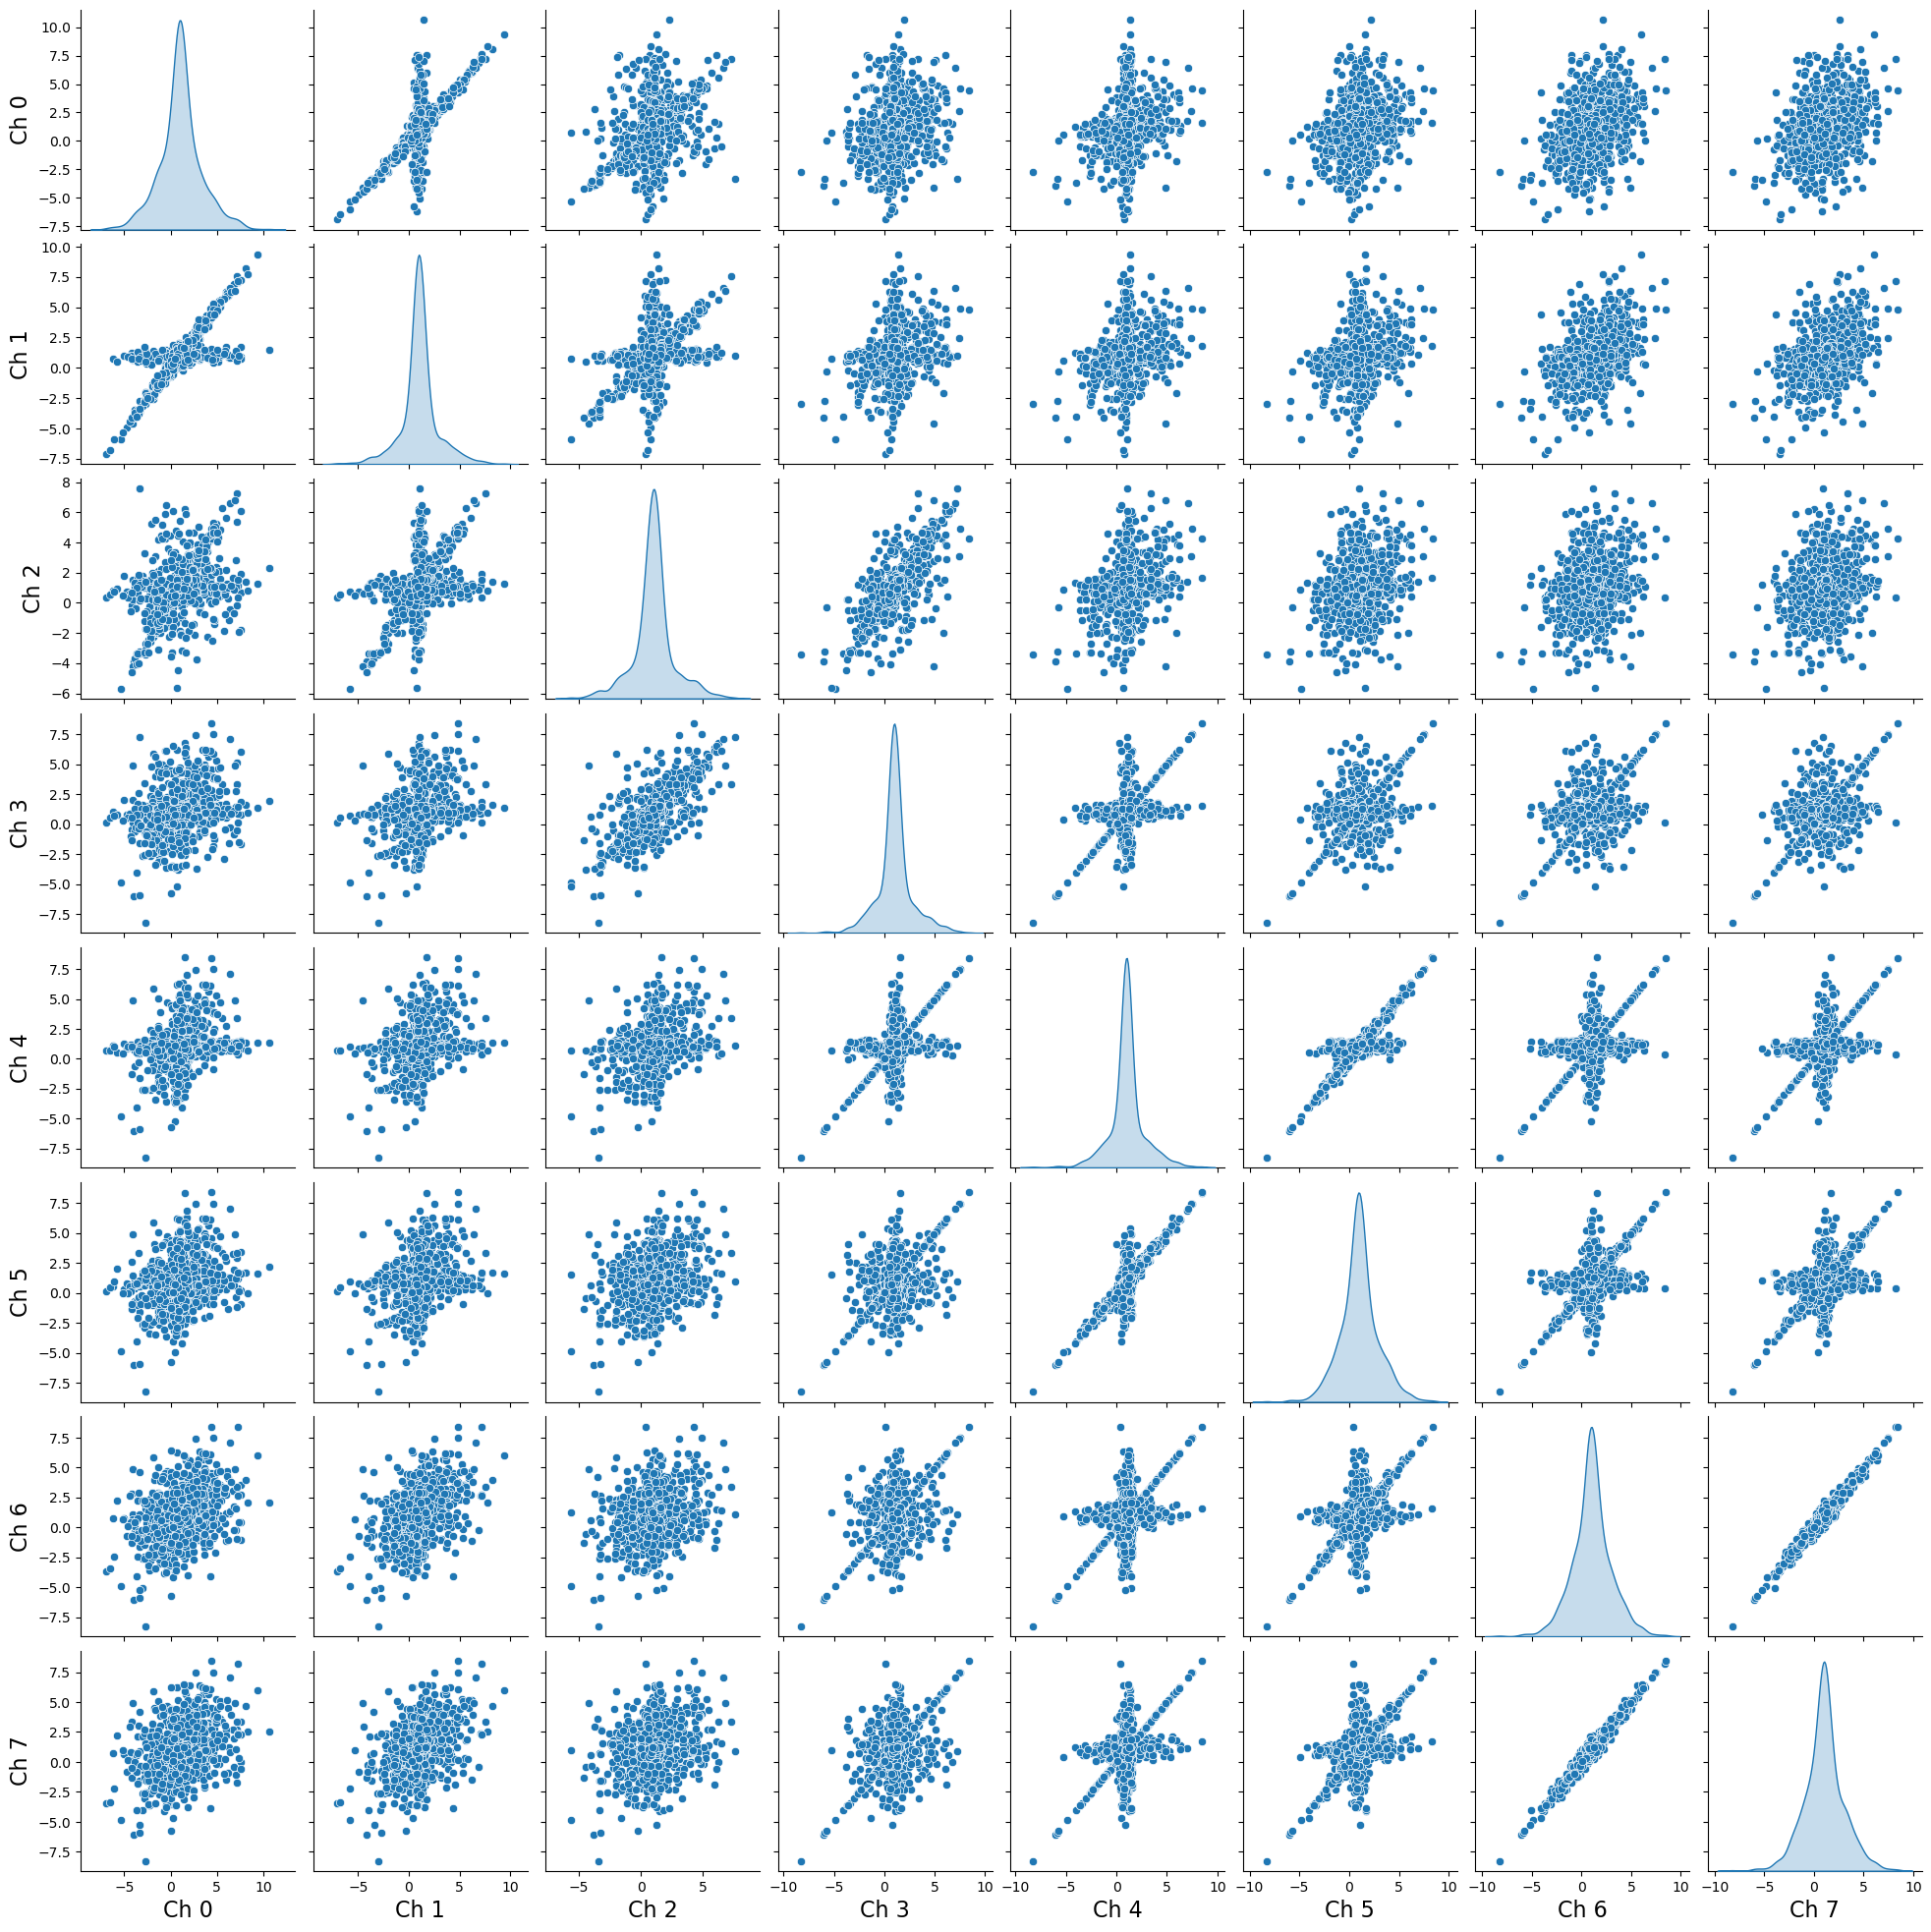

In [63]:
sns.pairplot(samples,diag_kind="kde")

<Axes: xlabel='0', ylabel='1'>

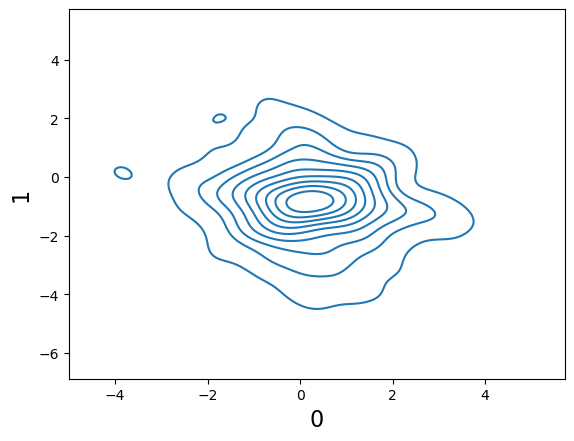

In [64]:
decoder = test_subject.decoder[-2:,:]
output = decoder[:,0:8:] @ samples.T

plt.figure()
sns.kdeplot(output.T,x=0,y=1)

## now with 64 dimensions

In [30]:
# mixture of gaussians 

n_dimensions = 64
n_gaussians = 32
n_samples = 2000
mixture_weights = np.ones(shape=(n_gaussians)) / n_gaussians

mixture_idxs = np.random.choice(n_gaussians, size=n_samples, replace=True, p=mixture_weights)

means = np.row_stack([np.ones(n_dimensions) for _ in range(n_gaussians)])
covariances = []
multiple = n_dimensions//n_gaussians
for i in range(n_gaussians):
    cov = np.random.random(size=(n_dimensions,n_dimensions))*0.5
    cov += cov.T
    k = i*multiple
    length = 2
    cov[k:k+length,k:k+length] = 10
    covariances.append(cov)
covariances = np.array(covariances)
print(covariances.shape)

samples = pd.DataFrame(np.array([np.random.multivariate_normal(means[i], covariances[i]) for i in mixture_idxs]),columns=[f"Ch {j}" for j in range(n_dimensions)])
print(samples.shape)

(32, 64, 64)


/var/folders/dz/870p8tdx43j5527kzthy65zw0000gn/T/ipykernel_63166/1950490386.py:23: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = pd.DataFrame(np.array([np.random.multivariate_normal(means[i], covariances[i]) for i in mixture_idxs]),columns=[f"Ch {j}" for j in range(n_dimensions)])


(2000, 64)


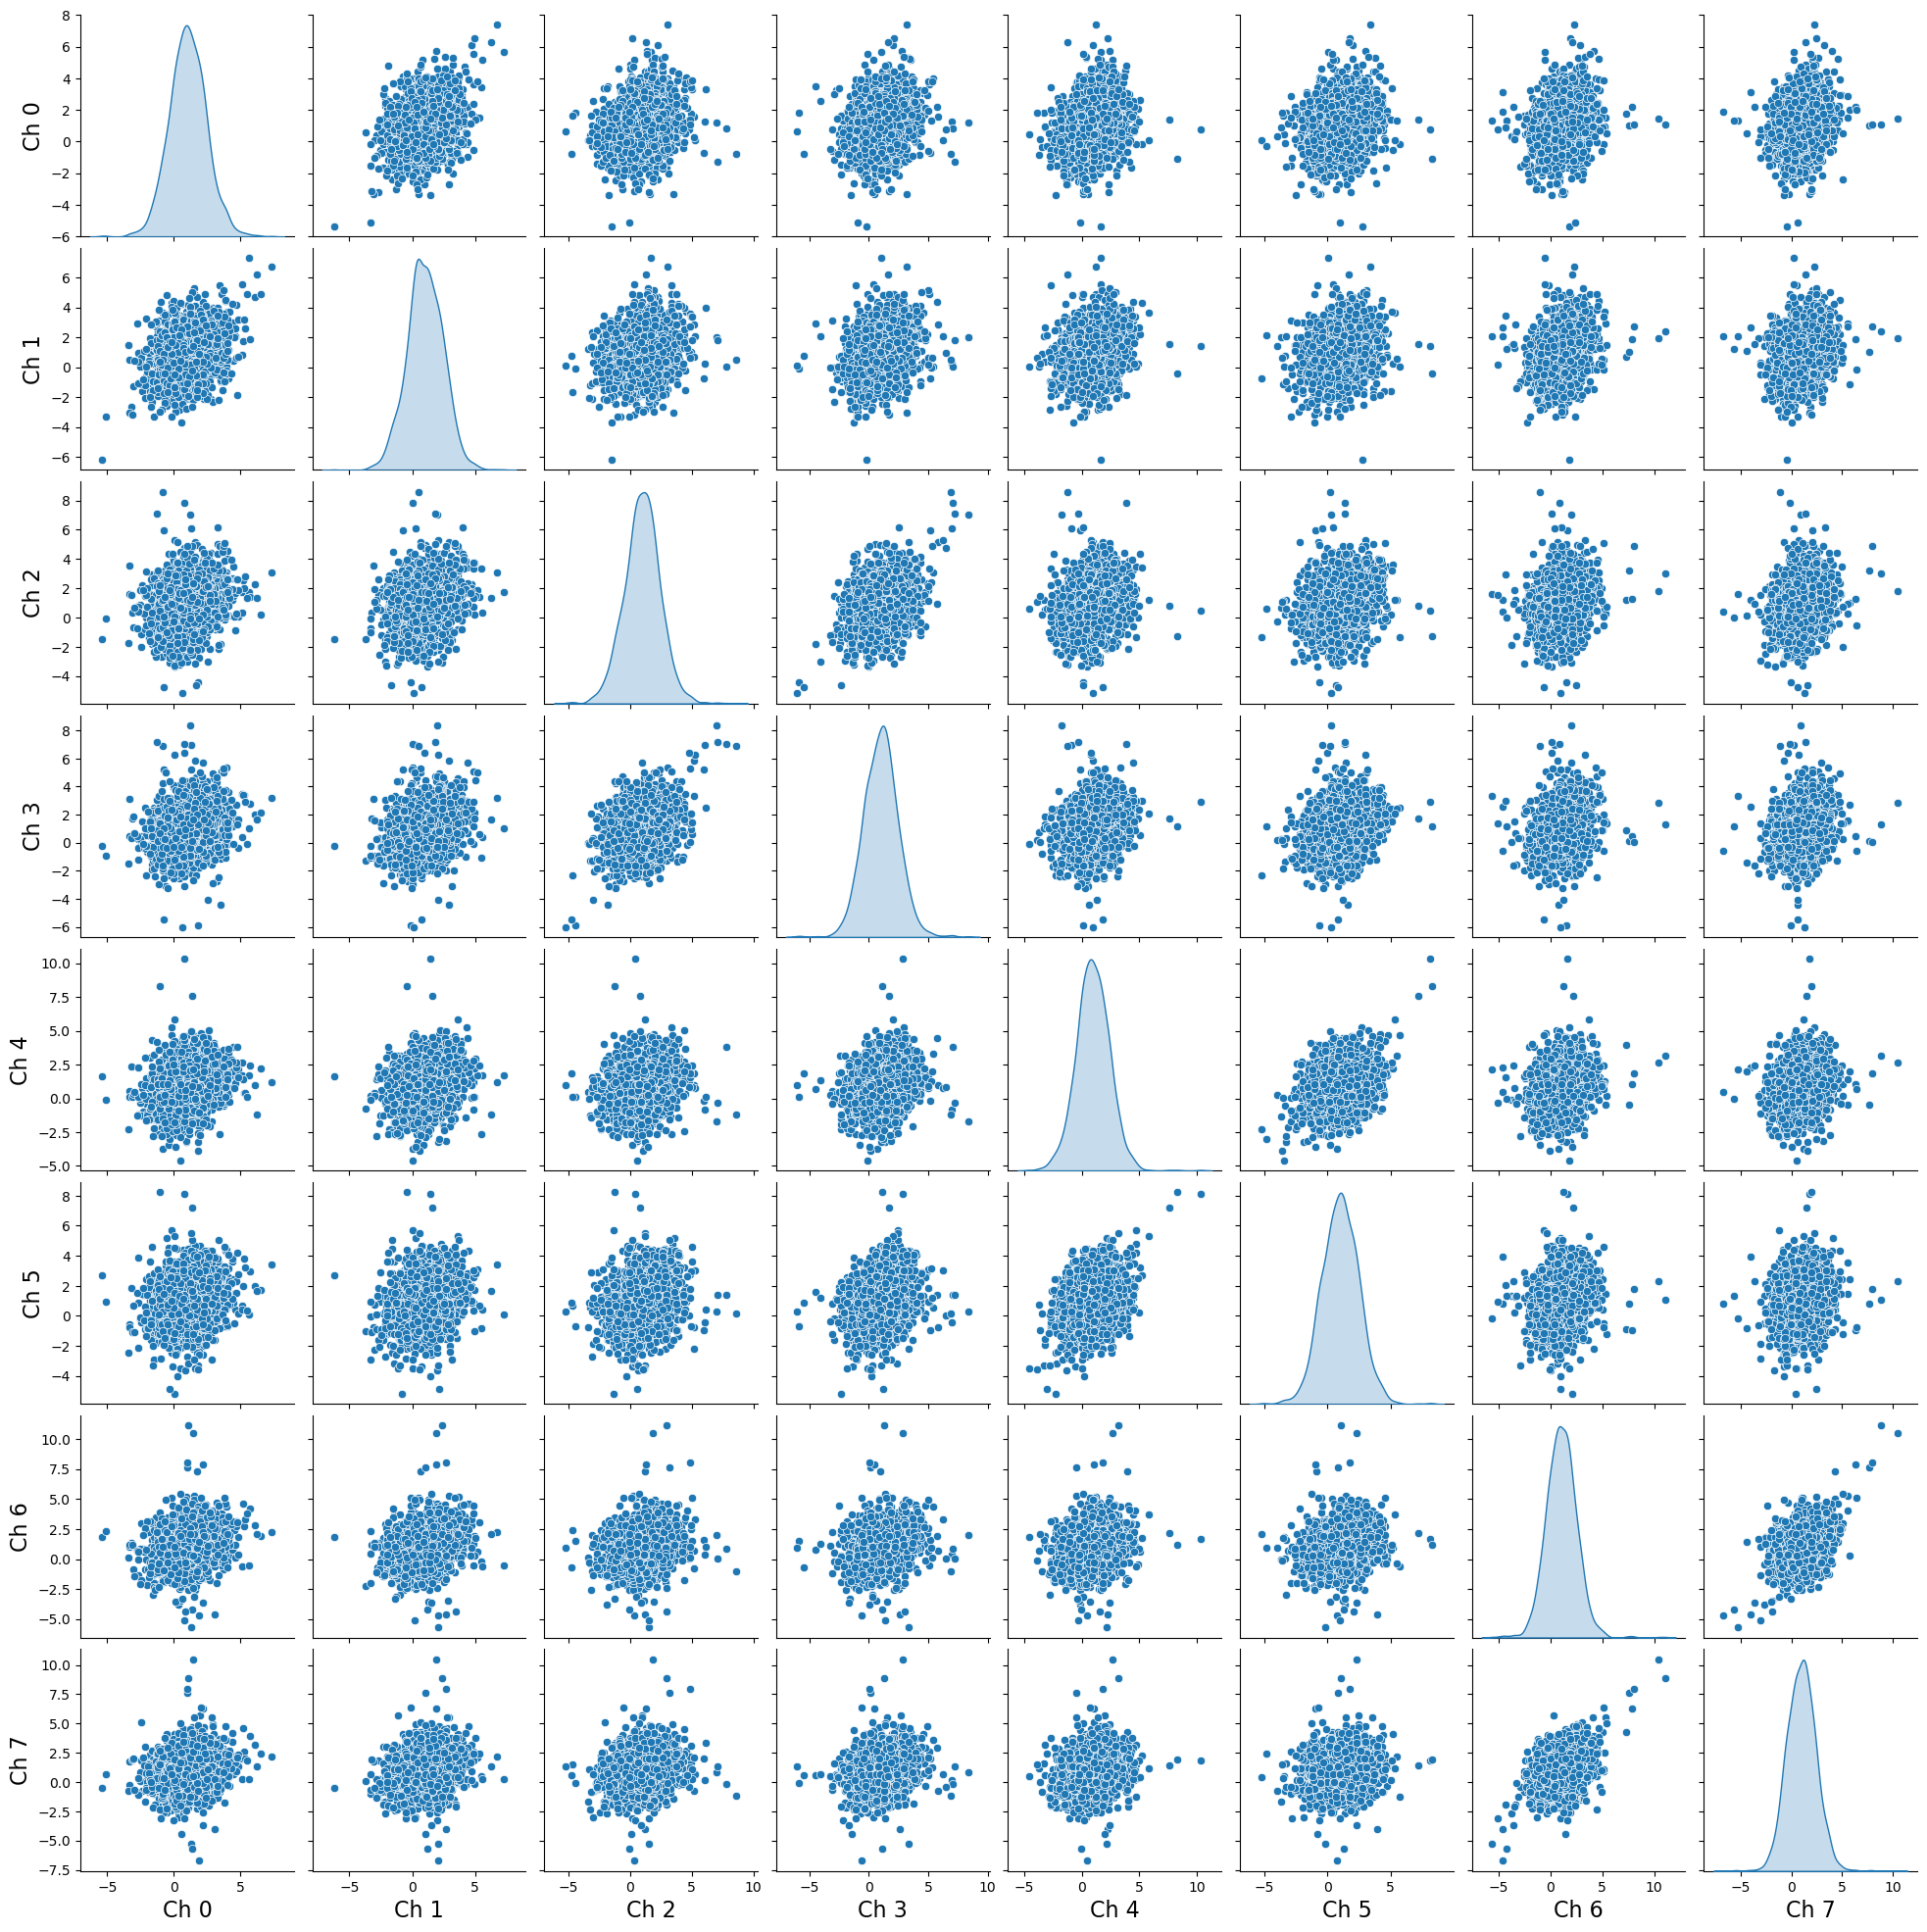

In [31]:
sns.pairplot(samples.iloc[:,:8],diag_kind="kde")

In [100]:
output.shape

(2, 500)

In [ ]:
decoder = test_subject.decoder[-2:,:]

output = decoder @ samples.T

sns.displot(output.T,x=0,y=1,kind='kde')

## fit some data with MoGs and sample

In [69]:
trial = test_subject.tasks["center_hold"].sorted_sessions()[15].sorted_trials()[3]
emg = trial.get_filtered_emg()[trial.active_indices]

from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=8, random_state=0).fit(emg)

In [ ]:
for i in range(8):
    plt.figure()
    plt.imshow(gm.covariances_[i])

# sort by row norms
for i in range(8):
    plt.figure()
    idxs = np.argsort(np.diag(gm.covariances_[i]))[::-1]
    plt.imshow(gm.covariances_[i][idxs,:][:,idxs])


In [94]:
# make a weird covariance

d = 64
c = np.random.random(size=(d,d))*0.1
x = np.linspace(0.1,4,d)
channel = 8
x = np.roll(x, channel)
x[:channel] = x[channel:]
c[channel,:] = x
c[:,channel] = x

plt.imshow(c)

ValueError: could not broadcast input array from shape (56,) into shape (8,)

In [75]:
samples = gm.sample(500)[0]
print(samples.shape)

(500, 64)


(2, 248)


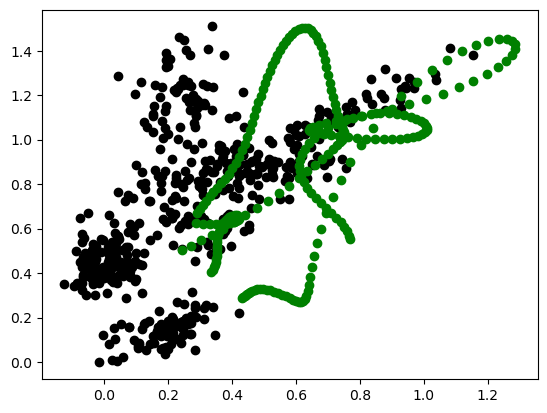

In [82]:
decoder = test_subject.decoder[-2:,:]
output = decoder @ samples.T

traj = trial.get_trajectory()[trial.active_indices].T
print(traj.shape)

plt.plot(output[0],output[1],"ko")
plt.plot(traj[0],traj[1],"go")